In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
#np.seterr(divide='print', invalid='print')
from scipy.sparse import hstack, csr_matrix
from xgboost import XGBClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import IPython
from plotly.offline import init_notebook_mode
%matplotlib inline
import plotly.offline as offline
from sklearn.calibration import CalibratedClassifierCV
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import pickle

from common_functions import *

## Dataset - Loading

In [2]:
train_dataset = pd.read_csv("data/UNSW_NB15_training-set.csv", encoding = "ISO-8859-1")
train_dataset.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [3]:
test_dataset = pd.read_csv("data/UNSW_NB15_testing-set.csv", encoding = "ISO-8859-1")
test_dataset.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [4]:
X_train, X_cv, y_train, y_cv = train_test_split(train_dataset.drop(['attack_cat', 'label'], axis=1), train_dataset.label, stratify=train_dataset.label, test_size=0.20)
X_test, y_test = test_dataset.drop(['attack_cat', 'label'], axis=1), test_dataset.label

In [5]:
with open("binary_features", "rb") as fp:   # Unpickling binary features
    binary_features = pickle.load(fp)

with open("categorical_features", "rb") as fp:   # Unpickling categorical features
    categorical_features = pickle.load(fp)

with open("numerical_features", "rb") as fp:   # Unpickling numerical features
    numerical_features = pickle.load(fp)


In [6]:
X_train, X_cv, y_train, y_cv = train_test_split(train_dataset.drop(['label'], axis=1), train_dataset.label, stratify=train_dataset.label, test_size=0.20)
X_test, y_test = test_dataset.drop(['label'], axis=1), test_dataset.label

one_hot_encoders, one_hot_encoders_features = fit_one_hot_encoders(X_train, categorical_features)
feature_standardizers = fit_standard_scalars(X_train, numerical_features)
minmax_scalers = fit_minmax_scalars(X_train, numerical_features)

X_train_encoded, X_train_encoded_features = merge_all(X_train, 
                                                      one_hot_encoders_features, 
                                                      get_one_hot_encoded_features(X_train, categorical_features, one_hot_encoders), 
                                                      get_standardized_features(X_train, numerical_features, feature_standardizers), 
                                                      binary_features)

X_cv_encoded, _ = merge_all(X_cv, one_hot_encoders_features, 
                                                      get_one_hot_encoded_features(X_cv, categorical_features, one_hot_encoders), 
                                                      get_standardized_features(X_cv, numerical_features, feature_standardizers), 
                                                      binary_features)

X_test_encoded, _ = merge_all(X_test, one_hot_encoders_features, 
                                                      get_one_hot_encoded_features(X_test, categorical_features, one_hot_encoders), 
                                                      get_standardized_features(X_test, numerical_features, feature_standardizers), 
                                                      binary_features)

#label encode attack category
y_encoder = LabelEncoder().fit(y_train)
y_train = np.array(y_encoder.transform(y_train))
y_cv = np.array(y_encoder.transform(y_cv))
y_test = np.array(y_encoder.transform(y_test))

#attack categories
print('\n y classes :' + str(y_encoder.classes_))


One Hot Encoding for proto
Feature Names are :
['25', '3pc', 'aes', 'any', 'argus', 'aris', 'arp', 'ax', 'bbn', 'bna', 'br', 'cbt', 'cftp', 'chaos', 'cmtp', 'compaq', 'cphb', 'cpnx', 'crtp', 'crudp', 'dcn', 'ddp', 'ddx', 'dgp', 'egp', 'eigrp', 'emcon', 'enc', 'encap', 'etherip', 'expak', 'fc', 'fire', 'frag', 'ggp', 'gmtp', 'gre', 'hmp', 'iatp', 'ib', 'icmp', 'idp', 'idpr', 'idrp', 'ifmp', 'igmp', 'igp', 'il', 'inp', 'ip', 'ipcomp', 'ipcv', 'ipip', 'iplt', 'ipnip', 'ippc', 'ipv6', 'ipx', 'irtp', 'isis', 'iso', 'kryptolan', 'l2tp', 'larp', 'leaf', 'merit', 'mfe', 'mhrp', 'micp', 'mobile', 'mon', 'mtp', 'mux', 'narp', 'nd', 'netblt', 'nlsp', 'no', 'nsfnet', 'nsp', 'nvp', 'opts', 'ospf', 'peer', 'pgm', 'pim', 'pipe', 'pnni', 'pri', 'prm', 'ptp', 'pup', 'pvp', 'qnx', 'rcc', 'rdp', 'route', 'rpc', 'rsvp', 'rtp', 'rvd', 'sat', 'sccopmce', 'scps', 'sctp', 'sdrp', 'secure', 'sep', 'skip', 'sm', 'smp', 'snp', 'sp3', 'sprite', 'sps', 'srp', 'st2', 'stp', 'sun', 'swipe', 'tcf', 'tcp', 'tlsp', 't

### a. Attack Detection

#### 0. Random Model


Log loss on Cross Validation Data using Random Model 0.8895728622875049
Log loss on Test Data using Random Model 0.8906677058876067
Number of misclassified points  49.99149783802167
-------------------------------------------------- Confusion matrix --------------------------------------------------


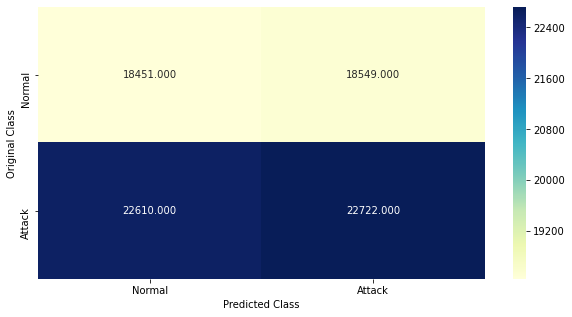

-------------------------------------------------- Precision matrix --------------------------------------------------


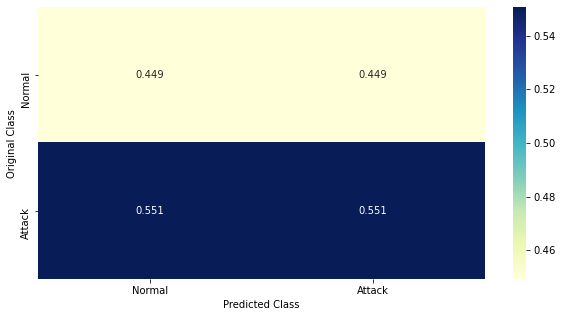

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


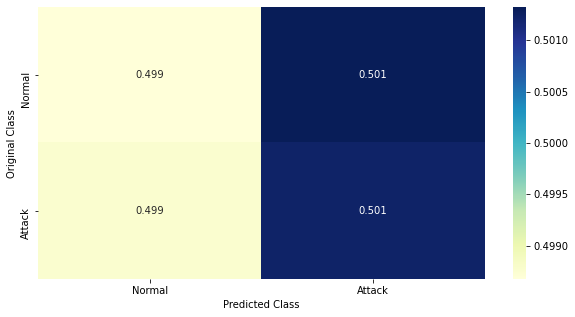

Sum of rows in precision matrix [1. 1.]


In [7]:
test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

cv_predicted_y = np.zeros((cv_data_len, 2))

for i in range(cv_data_len):
    rand_probs = np.random.rand(1, 2)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

print("\nLog loss on Cross Validation Data using Random Model",log_loss(y_cv, cv_predicted_y))

# Test-Set error.
test_predicted_y = np.zeros((test_data_len, 2))
for i in range(test_data_len):
    rand_probs = np.random.rand(1, 2)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [8]:
model_labels = dict()

#### 1. K-Nearest Neigbors

100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [9:45:34<00:00, 3513.44s/it]


log_loss for k =  20 is 0.13935565063141564
log_loss for k =  22 is 0.13899945428292404
log_loss for k =  24 is 0.13884274025094123
log_loss for k =  26 is 0.13865042019368026
log_loss for k =  28 is 0.13851604762718878
log_loss for k =  30 is 0.1383310950302237
log_loss for k =  32 is 0.13828376394715616
log_loss for k =  34 is 0.13817787822281347
log_loss for k =  36 is 0.1382729866545509
log_loss for k =  38 is 0.13819669743381466


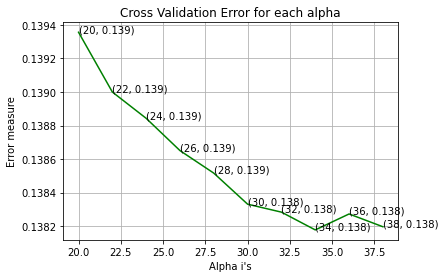

log loss for train data 0.1290328169466438
log loss for cv data 0.13817787822281347
log loss for test data 0.34159535466507185
Number of misclassified points  16.37394937569839
-------------------------------------------------- Confusion matrix --------------------------------------------------


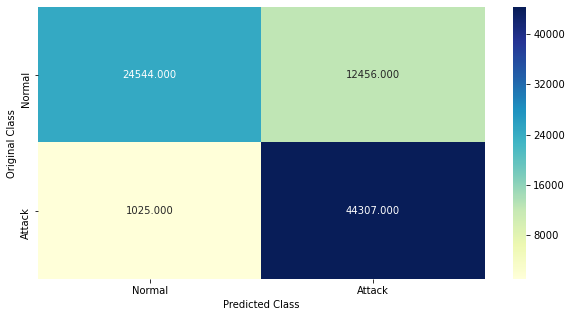

-------------------------------------------------- Precision matrix --------------------------------------------------


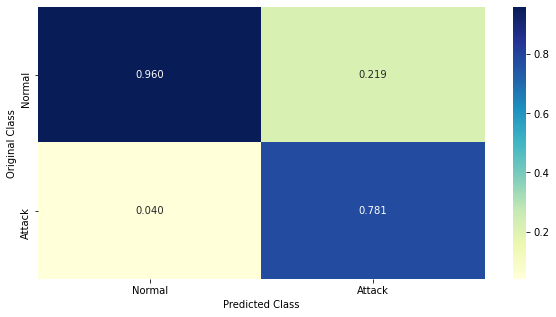

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


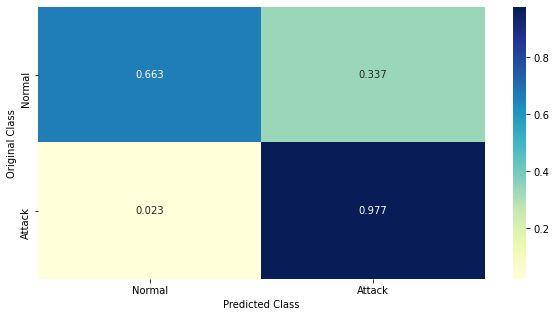

Sum of rows in precision matrix [1. 1.]


In [9]:
alpha = [x for x in range(20, 40, 2)]
cv_log_error_array=[]
for i in tqdm(alpha, position=0, leave=True):
    k_cfl=KNeighborsClassifier(n_neighbors=i, n_jobs=3)
    k_cfl.fit(X_train_encoded,y_train)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train_encoded, y_train)
    predict_y = sig_clf.predict_proba(X_cv_encoded)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is', cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha], n_jobs=3)
k_cfl.fit(X_train_encoded,y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train_encoded, y_train)
pred_y=sig_clf.predict(X_test_encoded)

predict_y = sig_clf.predict_proba(X_train_encoded)
print ('log loss for train data', log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv_encoded)
print ('log loss for cv data',log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test_encoded)
print ('log loss for test data',log_loss(y_test, predict_y))
plot_confusion_matrix(y_test,sig_clf.predict(X_test_encoded))

#storing model
model_labels['knn'] = sig_clf

#### 2. Logistic Regression

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:16<00:00, 15.37s/it]


log_loss for c =  0.001 is 0.23393748405887355
log_loss for c =  0.01 is 0.23992432291491414
log_loss for c =  0.1 is 0.20436243257423917
log_loss for c =  1 is 0.18391410423008925
log_loss for c =  10 is 0.18340917572351387


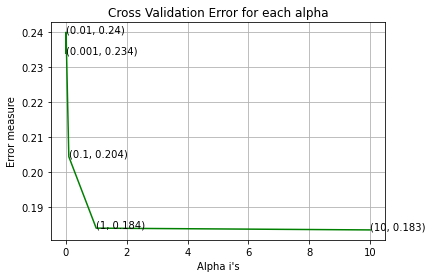

log loss for train data 0.18175221309801612
log loss for cv data 0.18340917572351387
log loss for test data 0.34234014426014125
Number of misclassified points  18.811640674342904
-------------------------------------------------- Confusion matrix --------------------------------------------------


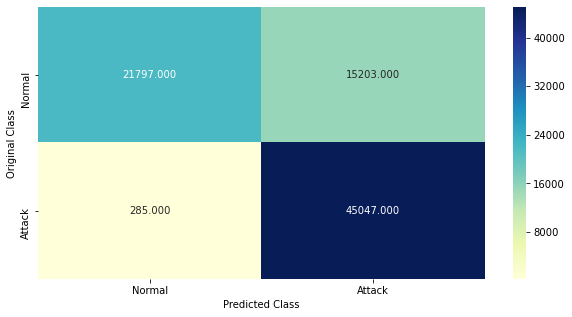

-------------------------------------------------- Precision matrix --------------------------------------------------


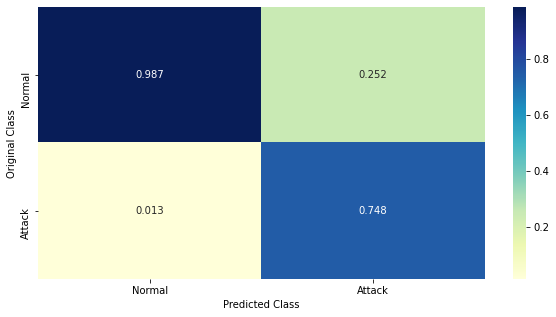

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


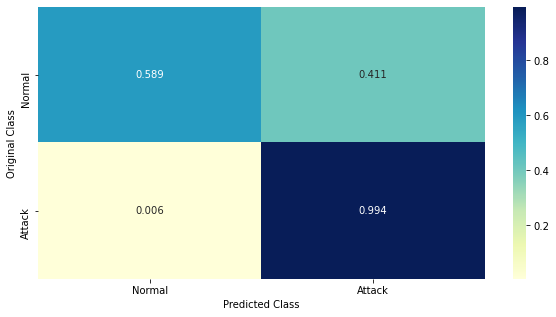

Sum of rows in precision matrix [1. 1.]


In [10]:
alpha = [10 ** x for x in range(-3, 2)]
cv_log_error_array=[]
for i in tqdm(alpha, position=0, leave=True):
    logisticR=LogisticRegression(penalty='l2', C=i, class_weight='balanced', n_jobs=3)
    logisticR.fit(X_train_encoded,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train_encoded, y_train)
    predict_y = sig_clf.predict_proba(X_cv_encoded)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced', n_jobs=3)
logisticR.fit(X_train_encoded,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train_encoded, y_train)

predict_y = sig_clf.predict_proba(X_train_encoded)
print ('log loss for train data',(log_loss(y_train, predict_y)))
predict_y = sig_clf.predict_proba(X_cv_encoded)
print ('log loss for cv data',(log_loss(y_cv, predict_y)))
predict_y = sig_clf.predict_proba(X_test_encoded)
print ('log loss for test data',(log_loss(y_test, predict_y)))
plot_confusion_matrix(y_test, sig_clf.predict(X_test_encoded))

#storing model
model_labels['lr'] = sig_clf

#### 3. Random Forest

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [1:45:52<00:00, 1270.54s/it]


log_loss for c =  10 is 0.10510964253475791
log_loss for c =  50 is 0.10198785498211192
log_loss for c =  100 is 0.10176351794385631
log_loss for c =  500 is 0.1015292104053428
log_loss for c =  1000 is 0.10144809031777904


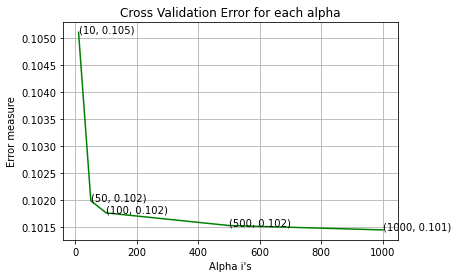

log loss for train data 0.025906466879293395
log loss for cv data 0.10144809031777904
log loss for test data 0.29379918255323123
Number of misclassified points  12.349997570810864
-------------------------------------------------- Confusion matrix --------------------------------------------------


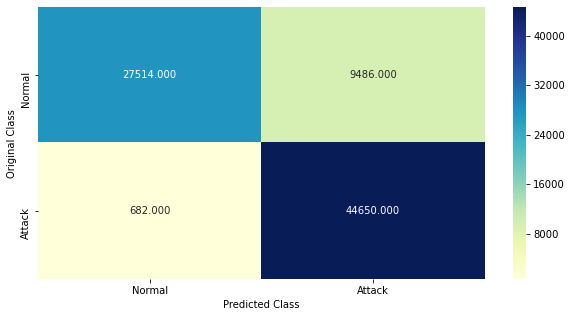

-------------------------------------------------- Precision matrix --------------------------------------------------


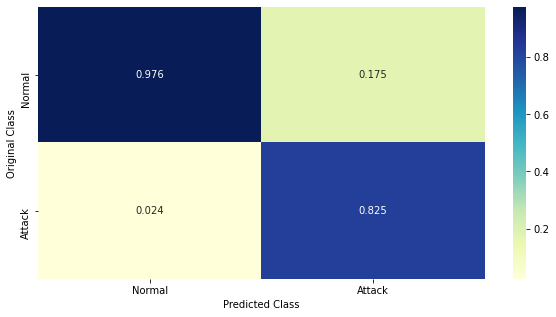

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


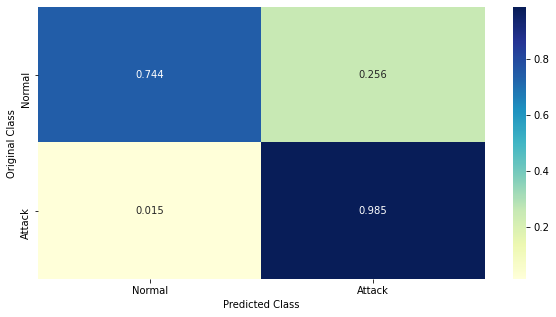

Sum of rows in precision matrix [1. 1.]


In [11]:
alpha=[10, 50, 100, 500, 1000]
cv_log_error_array=[]
for i in tqdm(alpha, position=0, leave=True):
    r_cfl=RandomForestClassifier(n_estimators=i, random_state=42, n_jobs=3)
    r_cfl.fit(X_train_encoded,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_encoded, y_train)
    predict_y = sig_clf.predict_proba(X_cv_encoded)
    cv_log_error_array.append(log_loss(y_cv, predict_y))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-3)
r_cfl.fit(X_train_encoded,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_encoded, y_train)
predict_y = sig_clf.predict_proba(X_train_encoded)
print ('log loss for train data',(log_loss(y_train, predict_y)))
predict_y = sig_clf.predict_proba(X_cv_encoded)
print ('log loss for cv data',(log_loss(y_cv, predict_y)))
predict_y = sig_clf.predict_proba(X_test_encoded)
print ('log loss for test data',(log_loss(y_test, predict_y)))
plot_confusion_matrix(y_test,sig_clf.predict(X_test_encoded))

#storing model
model_labels['rf'] = sig_clf

### Feature Importance for Random Forest Model

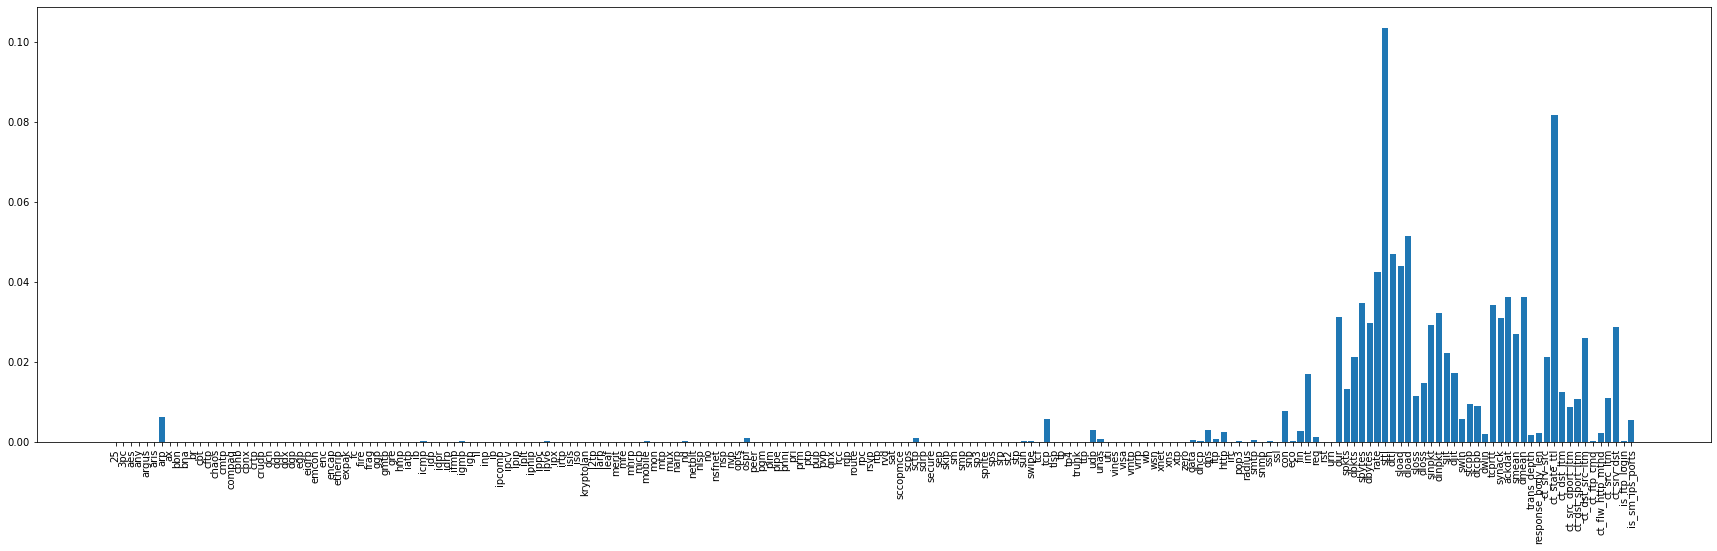

In [20]:
plt.figure(figsize=(30, 8))
plt.xticks(rotation=90)
plt.bar(X_train_encoded_features, model_labels['rf'].base_estimator.feature_importances_)
plt.show()

### Showing top 30 important features

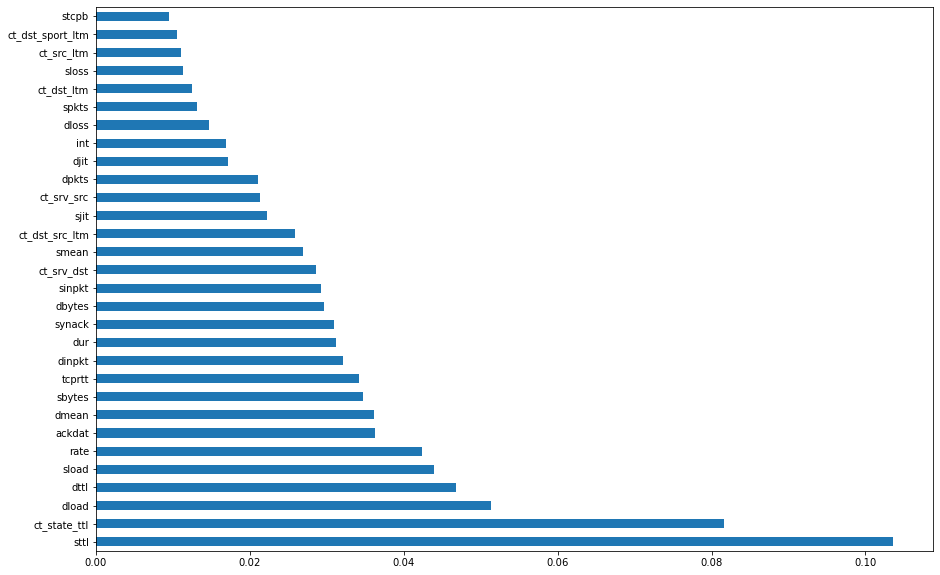

In [27]:
plt.figure(figsize=(15, 10))
pd.Series(model_labels['rf'].base_estimator.feature_importances_, index=X_train_encoded_features).nlargest(30).plot(kind='barh')
plt.show()

#### 4. XGBoost

log_loss for c =  50 is 0.1296067593346246
log_loss for c =  100 is 0.12476841637474481
log_loss for c =  200 is 0.12081233674848312
log_loss for c =  500 is 0.11296092966813338
log_loss for c =  1000 is 0.10794411865709092


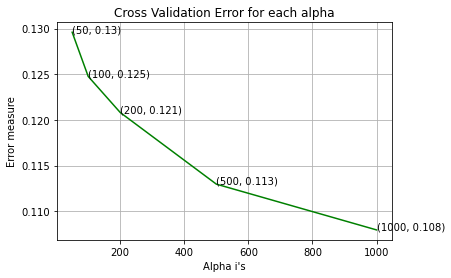

For values of best alpha =  1000 The train log loss is: 0.09088795166897075
For values of best alpha =  1000 The cross validation log loss is: 0.10794411865709092
For values of best alpha =  1000 The test log loss is: 0.29221693314913255
Number of misclassified points  11.833794879269298
-------------------------------------------------- Confusion matrix --------------------------------------------------


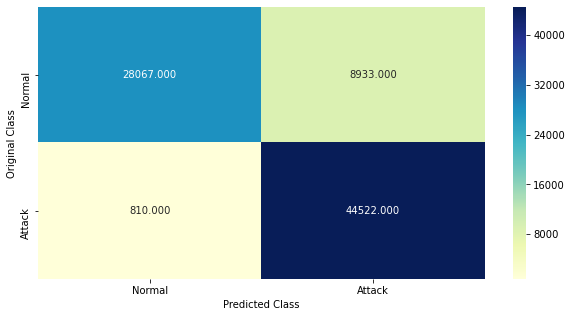

-------------------------------------------------- Precision matrix --------------------------------------------------


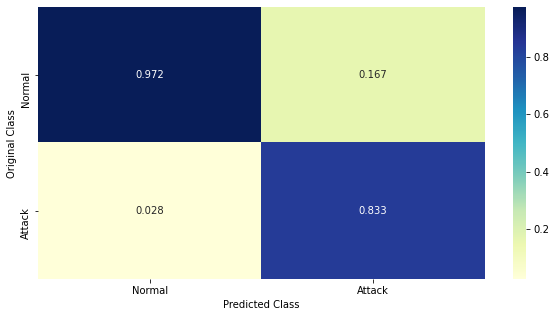

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


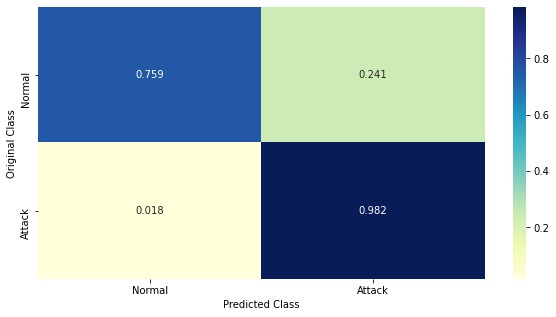

Sum of rows in precision matrix [1. 1.]


In [12]:
alpha=[50, 100, 200, 500, 1000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i, nthread=3)
    x_cfl.fit(X_train_encoded,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_encoded, y_train)
    predict_y = sig_clf.predict_proba(X_cv_encoded)
    cv_log_error_array.append(log_loss(y_cv, predict_y))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha], nthread=4)
x_cfl.fit(X_train_encoded,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_encoded, y_train)
    
predict_y = sig_clf.predict_proba(X_train_encoded)

print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv_encoded)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test_encoded)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test_encoded))

#storing model
model_labels['xgb'] = sig_clf

### Feature Importance for XGBoost Model

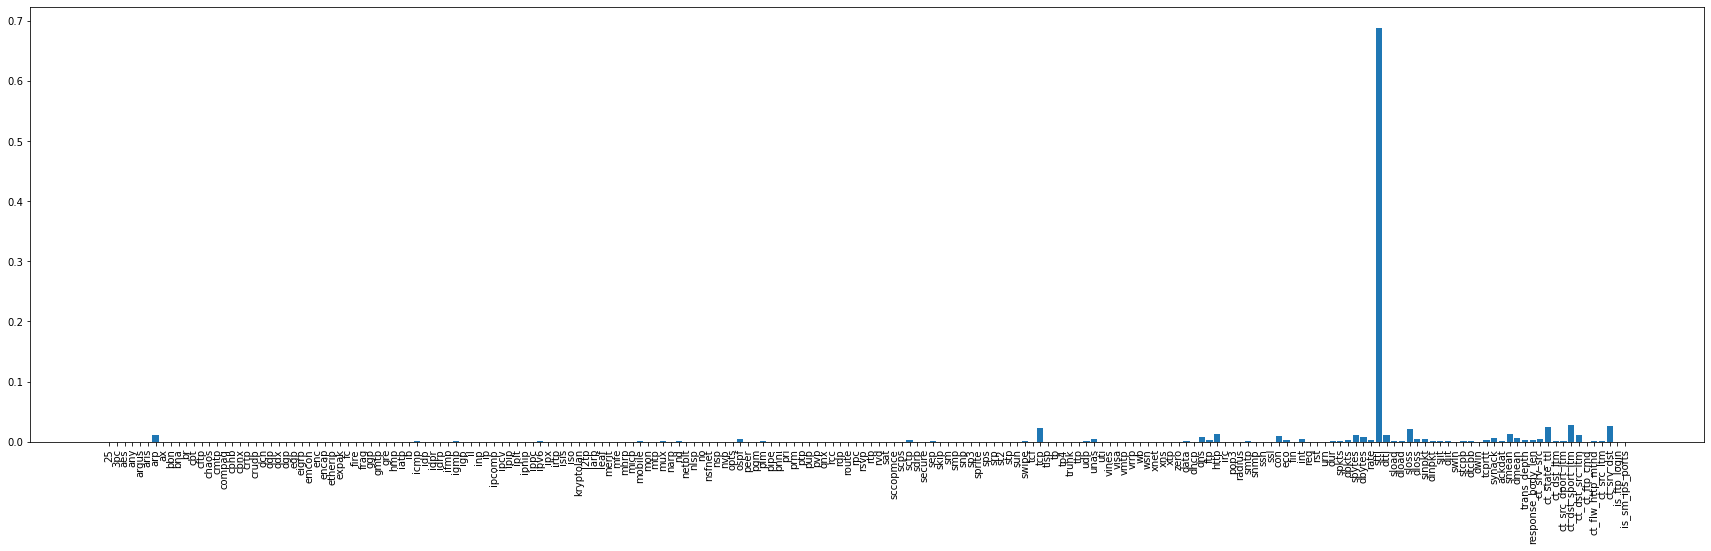

In [18]:
plt.figure(figsize=(30, 8))
plt.xticks(rotation=90)
plt.bar(X_train_encoded_features, model_labels['xgb'].base_estimator.feature_importances_)
plt.show()

### Showing top 30 important features

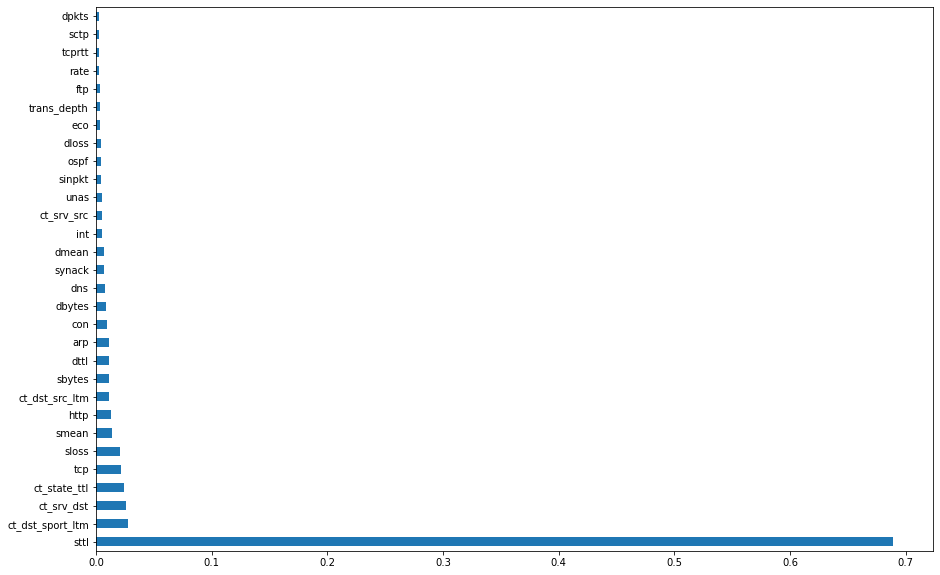

In [28]:
plt.figure(figsize=(15, 10))
pd.Series(model_labels['xgb'].base_estimator.feature_importances_, index=X_train_encoded_features).nlargest(30).plot(kind='barh')
plt.show()

#### 5. Decision Tree

Best Parameters :{'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2}
The train log loss is: 0.0030783832161488385
The cross validation log loss is: 1.618403721041269
The test log loss is: 4.651907357964286
Number of misclassified points  13.59860078705728
-------------------------------------------------- Confusion matrix --------------------------------------------------


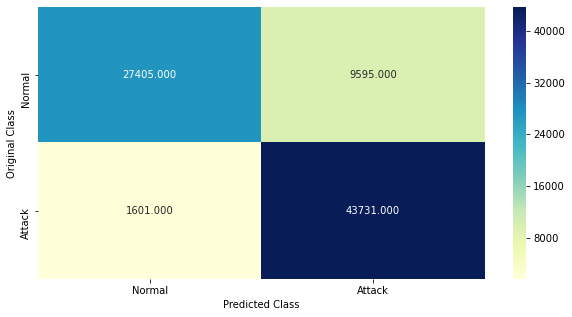

-------------------------------------------------- Precision matrix --------------------------------------------------


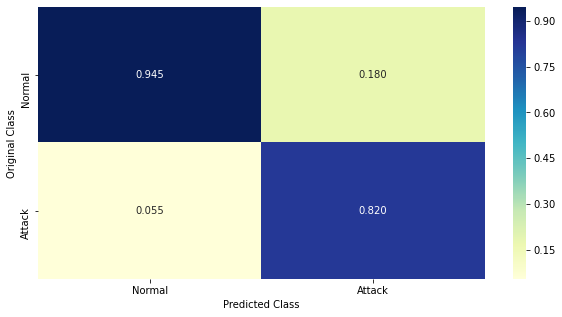

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


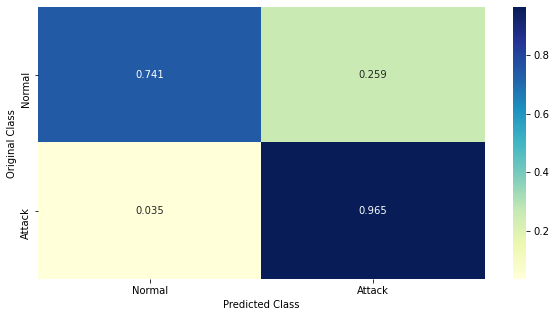

Sum of rows in precision matrix [1. 1.]


In [14]:
param_grid = {'max_depth': [None, 8, 10, 12, 14], 'class_weight':['balanced'], 'min_samples_split':[2, 3, 4, 6, 10]}

tree = GridSearchCV(DecisionTreeClassifier(), param_grid)
tree.fit(X_train_encoded, y_train)
print('Best Parameters :'+ str(tree.best_params_))
predict_y = tree.predict_proba(X_train_encoded)

print ("The train log loss is:",log_loss(y_train, predict_y))
predict_y = tree.predict_proba(X_cv_encoded)
print("The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = tree.predict_proba(X_test_encoded)
print("The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, tree.predict(X_test_encoded))

#storing model
model_labels['dt'] = tree

### Feature Importance for Decision Tree Classifier Model

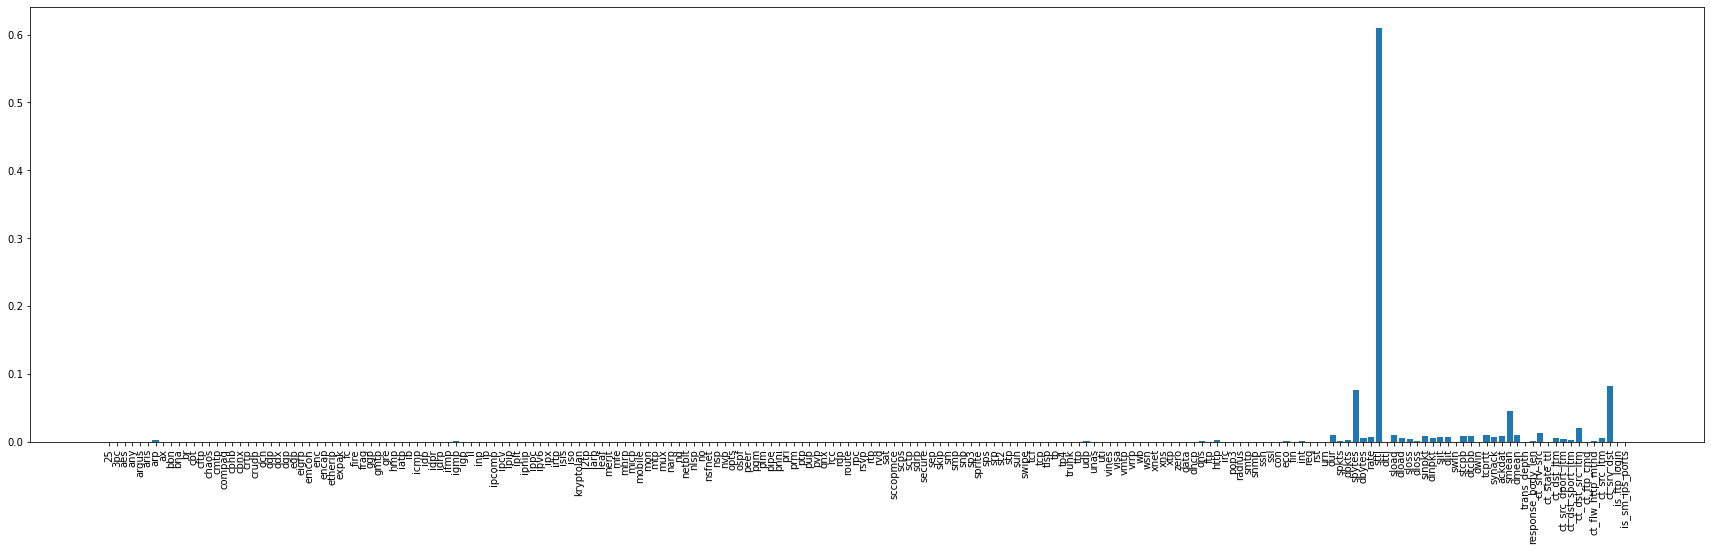

In [23]:
plt.figure(figsize=(30, 8))
plt.xticks(rotation=90)
plt.bar(X_train_encoded_features, model_labels['dt'].best_estimator_.feature_importances_)
plt.show()

### Showing top 30 important features

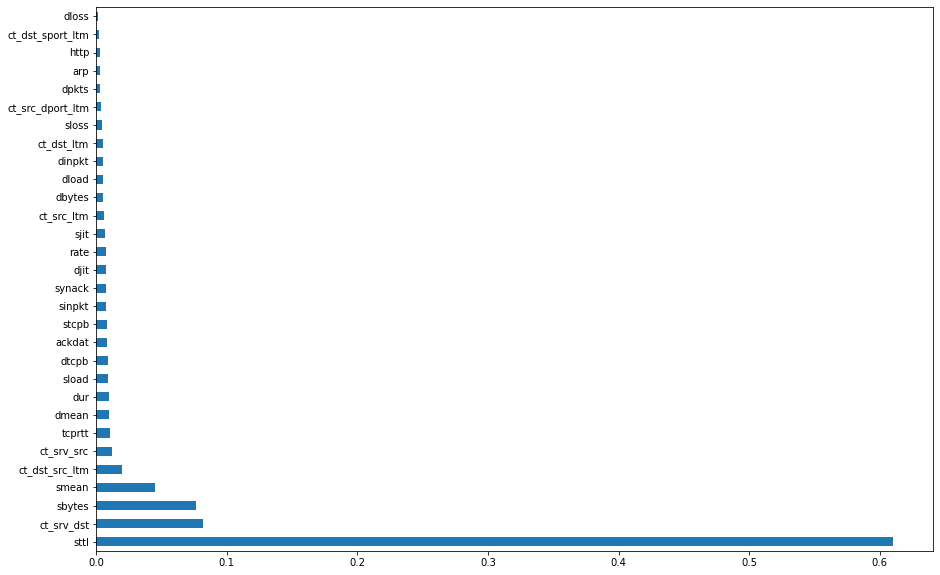

In [30]:
plt.figure(figsize=(15, 10))
pd.Series(model_labels['dt'].best_estimator_.feature_importances_, index=X_train_encoded_features).nlargest(30).plot(kind='barh')
plt.show()

#### 6. Neural Network

Train on 140272 samples, validate on 82332 samples
Epoch 1/100
140272/140272 [==============================] - 8s 58us/sample - loss: 0.1413 - accuracy: 0.9356 - val_loss: 0.2683 - val_accuracy: 0.8347
Epoch 2/100
140272/140272 [==============================] - 6s 42us/sample - loss: 0.1199 - accuracy: 0.9409 - val_loss: 0.2786 - val_accuracy: 0.8320
Epoch 3/100
140272/140272 [==============================] - 5s 39us/sample - loss: 0.1164 - accuracy: 0.9424 - val_loss: 0.2408 - val_accuracy: 0.8464
Epoch 4/100
140272/140272 [==============================] - 6s 42us/sample - loss: 0.1148 - accuracy: 0.9432 - val_loss: 0.2746 - val_accuracy: 0.8455
Epoch 5/100
140272/140272 [==============================] - 6s 42us/sample - loss: 0.1130 - accuracy: 0.9440 - val_loss: 0.3244 - val_accuracy: 0.8291
Epoch 6/100
140272/140272 [==============================] - 5s 37us/sample - loss: 0.1118 - accuracy: 0.9452 - val_loss: 0.2912 - val_accuracy: 0.8415
Epoch 7/100
140272/140272 [==========

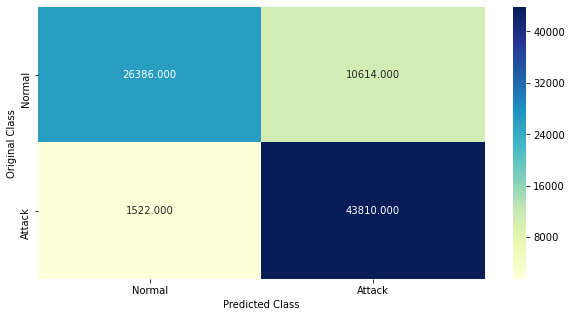

-------------------------------------------------- Precision matrix --------------------------------------------------


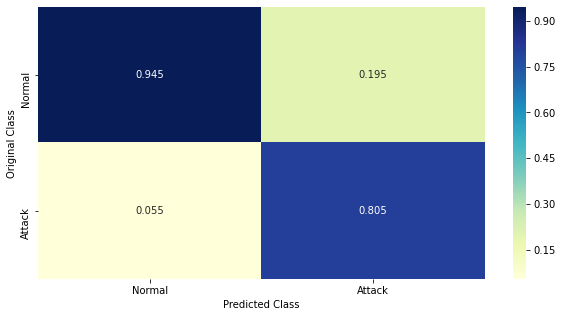

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


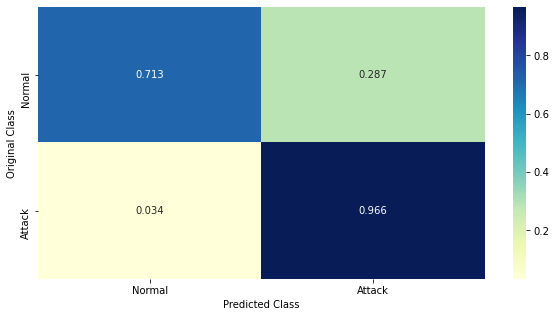

Sum of rows in precision matrix [1. 1.]


In [31]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train_encoded.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_encoded.todense(), y_train, batch_size=128, epochs=100, validation_data=(X_test_encoded.todense(), y_test))

print ("The train log loss is:", log_loss(y_train, model.predict_proba(X_train_encoded.todense()), eps=1e-7))
predict_y = tree.predict_proba(X_cv_encoded)
print("The cross validation log loss is:", log_loss(y_cv, model.predict_proba(X_cv_encoded.todense()), eps=1e-7))
predict_y = tree.predict_proba(X_test_encoded)
print("The test log loss is:", log_loss(y_test, model.predict_proba(X_test_encoded.todense()), eps=1e-7))

plot_confusion_matrix(y_test, [int(np.round(x)) for x in model.predict_proba(X_test_encoded.todense())])

#storing model
model_labels['nn'] = model

#### Summary Table for Attack Detection

In [43]:
count = 1
models = ['knn', 'lr', 'rf', 'xgb', 'dt', 'nn']
model_names = {'knn':'K Nearest Neighbours', 'lr':'Logistic Regression', 'rf':'Random Forest', 'xgb':'XGBoost', 'dt':'Decision Tree', 'nn':'Neural Network'}

summary_table = PrettyTable()
summary_table.field_names = ['Sr. No.', 'Classifier', 'Log Loss', 'Overall Accuracy', 'Attack Detection Accuracy']

for count, model in enumerate(models, start=1):
    if model == 'nn':
        y_pred = [int(np.round(x)) for x in model_labels[model].predict(X_test_encoded.todense())]
        y_proba = model_labels[model].predict_proba(X_test_encoded.todense())
    else:
        y_pred = model_labels[model].predict(X_test_encoded)
        y_proba = model_labels[model].predict_proba(X_test_encoded)
        
    C = confusion_matrix(y_test, y_pred)
    A =(((C.T)/(C.sum(axis=1))).T)    
    
    ada = str(round(A[1][1] * 100, 2)) + ' %'
        
    summary_table.add_row([str(count), 
                           str(model_names[model]), 
                           str(round(log_loss(y_test, y_proba, eps=1e-7), 4)), 
                           str(round(accuracy_score(y_test, y_pred) * 100, 2)) + ' %', 
                           ada])
    
print(summary_table)

+---------+----------------------+----------+------------------+---------------------------+
| Sr. No. |      Classifier      | Log Loss | Overall Accuracy | Attack Detection Accuracy |
+---------+----------------------+----------+------------------+---------------------------+
|    1    | K Nearest Neighbours |  0.3416  |     83.63 %      |          97.74 %          |
|    2    | Logistic Regression  |  0.3423  |     81.19 %      |          99.37 %          |
|    3    |    Random Forest     |  0.2938  |     87.65 %      |           98.5 %          |
|    4    |       XGBoost        |  0.2922  |     88.17 %      |          98.21 %          |
|    5    |    Decision Tree     |  2.1722  |      86.4 %      |          96.47 %          |
|    6    |    Neural Network    |  0.4797  |     85.26 %      |          96.64 %          |
+---------+----------------------+----------+------------------+---------------------------+


In [ ]:
model_labels['nn'] = None
with open("nid_models", "wb") as fp:   #Pickling
    pickle.dump(model_labels, fp)